In [2]:
!nvidia-smi

Thu Apr 22 13:25:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers==3
!pip install torch

     |████████████████████████████████| 46.9MB 65kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 348kB 16.2MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595689 sha256=25eb42d19747a5ca54deaead2a0514697a06cde5e1ceb8fed69a9a47b6bffff1
  Stored in directory: /root/.cache/pip/wheels/37/65/52/63032864a0f31a08b9a88569f803b5bafac8abd207fd7f7534
Successfully built gluonnlp
     |████████████████████████████████| 1.2MB 14.6MB/s 
     |████████████████████████████████| 757kB 15.7MB/s 
     |████████████████████████████████| 3.0MB 31.7MB/s 
     |████████████████████████████████| 901kB 54.0MB/s 


In [4]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
from tqdm import tqdm, tqdm_notebook, notebook

In [5]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)
device = torch.device("cuda:0")

Thu Apr 22 13:26:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
##GPU 사용 시
device = torch.device("cuda:0")

In [7]:
torch.cuda.is_available()

True

In [8]:
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-9c7knz9r
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-9c7knz9r
  Created wheel for kobert: filename=kobert-0.1.2-cp37-none-any.whl size=12708 sha256=d48d32eb25dd02fdda2789f0e21826407765d7b369829788fc3dfe2a72d832e7
  Stored in directory: /tmp/pip-ephem-wheel-cache-7_jii9on/wheels/a2/b0/41/435ee4e918f91918be41529283c5ff86cd010f02e7525aecf3
Successfully built kobert


In [9]:
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model
from gluonnlp.data import SentencepieceTokenizer

from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import random
import time
import datetime


In [10]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [11]:
BASE_PATH = '/gdrive/MyDrive/210422'
# data_2019 = glob.glob(BASE_PATH + '/*') # + '*'

In [12]:
bertmodel, vocab = get_pytorch_kobert_model()

[██████████████████████████████████████████████████]
[██████████████████████████████████████████████████]


In [13]:
import pandas as pd
import numpy as np
df = pd.read_csv(BASE_PATH+'/210422_second.csv', encoding="utf-8", dtype=np.object) # index_col=[0], #dtype=np.object)
df.head(3)

,category,isbn,name,toc,text,n5,n100,n10,x,ready,input
0,1001001,9791125495970,민주선생님 똑소리나는 육아 우리 아이 훈육편,훈육 바로알기 들어가기 훈육의 개념 정리 훈육의 적절한 시기 훈육 실패하지 않기 위...,부모는 육아를 위해 끊임없이 고민합니다 그런 과정을 통해 아이가 크는 만큼 부모도 ...,1359,5,59,민주선생님 똑소리나는 육아 우리 아이 훈육편 훈육 바로알기 들어가기 훈육의 개념 정...,"['민주', '선생', '소리', '육아', '아이', '훈육', '편', '훈육'...",민주 선생 소리 육아 아이 훈육 편 훈육 훈육 개념 정리 훈육 시기 훈육 실패 지침...
1,1001001,9791188915422,진짜 칭찬,들어가는 말 그 좋다는 칭찬에 우리는 왜 인색할까요 1장 칭찬이 내 아이를 키운다 ...,칭찬의 효과와 역효과 그리고 진짜 칭찬의 기술까지 칭찬에 대한 모든 것을 알려주는 ...,0359,5,59,진짜 칭찬 들어가는 말 그 좋다는 칭찬에 우리는 왜 인색할까요 1장 칭찬이 내 아이...,"['칭찬', '말', '칭찬', '인색', '장', '칭찬', '아이', '성공',...",칭찬 말 칭찬 인색 장 칭찬 아이 성공 실패 칭찬 힘 칭찬 힘 동기 자극 언어 보상...
2,1001001,9791160509618,반찬 없이도 테이블이 완벽해지는 솥밥,저자의 말 쌀의 종류 솥의 종류 육수 만들기 자주 쓰이는 양념과 재료 쌀밥 짓기 테...,몸도 마음도 따뜻해지는 완벽한 한 끼 솥밥 하루에도 몇 번씩 일상에서 하게 되는 인...,1359,5,59,반찬 없이도 테이블이 완벽해지는 솥밥 저자의 말 쌀의 종류 솥의 종류 육수 만들기 ...,"['반찬', '테이블', '완벽', '솥', '밥', '저자', '말', '쌀', ...",반찬 테이블 완벽 솥 밥 저자 말 쌀 종류 솥 종류 육수 양념 재료 쌀 밥 테이블 ...


  n100  count
0    0   2139
1    1   1973
2    2   1776
3    3   5213
4    4   2101
5    5   2732
6    6   2629
7    7    519
8    8   5103
9    9   2850


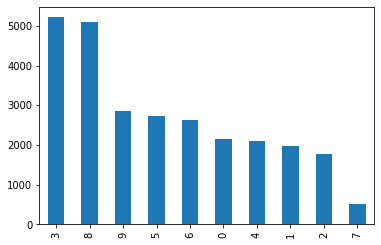

In [13]:
df['n100'].value_counts().plot(kind = 'bar')
print(df.groupby('n100').size().reset_index(name = 'count'))

In [ ]:
pd.set_option('display.max_rows', 200)
g2 = df.groupby('n10')
gg = g2.count()
gg['isbn'].sort_values(ascending=True)

In [ ]:
gg['isbn']

In [14]:
# mapping for classification

df['label'] = df['n10']
for i in range(len(df)):
    tmp = df['label'][i]
    if tmp == '00':
        df['label'][i] = '00'
    elif (tmp == '01' 
        or tmp == '02'
        or tmp == '03'
        or tmp == '04'
        or tmp == '05'
        or tmp == '06'
        or tmp == '07'
        or tmp == '08'
        or tmp == '09'):
        df['label'][i] = '01'
    elif (tmp == '10' 
        or tmp == '11'
        or tmp == '12'
        or tmp == '13'):
        df['label'][i] = '02'
    elif (tmp == '14' 
        or tmp == '15'):
        df['label'][i] = '03'
    elif (tmp == '16' 
        or tmp == '17'):
        df['label'][i] = '04'
    elif (tmp == '18'):
        df['label'][i] = '05'
    elif (tmp == '19'):
        df['label'][i] = '06'

    elif (tmp == '20' 
        or tmp == '21'
        or tmp == '24'
        or tmp == '25'
        or tmp == '26'
        or tmp == '27'
        or tmp == '28'
        or tmp == '29'):
        df['label'][i] = '07'
    elif (tmp == '22'):
        df['label'][i] = '08'
    elif (tmp == '23'):
        df['label'][i] = '09'

    elif (tmp == '30' 
        or tmp == '31'
        or tmp == '35'
        or tmp == '36'
        or tmp == '38'
        or tmp == '39'):
        df['label'][i] = '10'
    elif (tmp == '32'):
        df['label'][i] = '11'
    elif (tmp == '33'):
        df['label'][i] = '12'
    elif (tmp == '34'):
        df['label'][i] = '13'
    elif (tmp == '37'):
        df['label'][i] = '14'

    elif (tmp == '40'):
        df['label'][i] = '15'
    elif (tmp == '41' 
        or tmp == '42'):
        df['label'][i] = '16'
    elif (tmp == '44' 
        or tmp == '45'
        or tmp == '46'):
        df['label'][i] = '17'
    elif (tmp == '43' 
        or tmp == '47'):
        df['label'][i] = '18'
    elif (tmp == '48' 
        or tmp == '49'):
        df['label'][i] = '19'

    elif (tmp == '50' 
        or tmp == '52'
        or tmp == '53'
        or tmp == '54'
        or tmp == '55'
        or tmp == '57'
        or tmp == '58'):
        df['label'][i] = '20'
    elif (tmp == '51'):
        df['label'][i] = '21'
    elif (tmp == '56'):
        df['label'][i] = '22'
    elif (tmp == '59'):
        df['label'][i] = '23'
    
    elif (tmp == '60'):
        df['label'][i] = '24'
    elif (tmp == '61' 
        or tmp == '62'
        or tmp == '63'):
        df['label'][i] = '25'
    elif (tmp == '64' 
        or tmp == '65'
        or tmp == '66'):
        df['label'][i] = '26'
    elif (tmp == '67'):
        df['label'][i] = '27'
    elif (tmp == '68'):
        df['label'][i] = '28'
    elif (tmp == '69'):
        df['label'][i] = '29'

    elif (tmp == '70' 
        or tmp == '72'
        or tmp == '73'
        or tmp == '79'):
        df['label'][i] = '30'
    elif (tmp == '71'):
        df['label'][i] = '31'
    elif (tmp == '74'):
        df['label'][i] = '32'
    
    elif (tmp == '80' 
        or tmp == '89'):
        df['label'][i] = '33'
    elif (tmp == '81'):
        df['label'][i] = '34'
    elif (tmp == '82' 
        or tmp == '83'):
        df['label'][i] = '35'
    elif (tmp == '84' 
        or tmp == '85'
        or tmp == '86'
        or tmp == '87'
        or tmp == '88'):
        df['label'][i] = '36'

    elif (tmp == '90' 
        or tmp == '99'):
        df['label'][i] = '37'
    elif (tmp == '91'):
        df['label'][i] = '38'
    elif (tmp == '92' 
        or tmp == '93'
        or tmp == '94'
        or tmp == '95'
        or tmp == '96'
        or tmp == '97'):
        df['label'][i] = '39'
    elif (tmp == '98'):
        df['label'][i] = '40'

df.tail(2)


,category,isbn,name,toc,text,n5,n100,n10,x,ready,input,label
27033,1001047,9791186198599,빈칸 책,나의 탄생 나의 성질 나의 얼굴 나의 단어 나의 뇌구조 나의 손 나의 이름 나의 헤...,빈칸 책 은 말 그대로 빈칸 으로 가득한 책이다 빈칸 이 존재하는 까닭은 채워지기 ...,0380,8,80,빈칸 책 나의 탄생 나의 성질 나의 얼굴 나의 단어 나의 뇌구조 나의 손 나의 이름...,"['빈칸', '책', '탄생', '성질', '얼굴', '단어', '뇌', '구조',...",빈칸 책 탄생 성질 얼굴 단어 뇌 구조 손 이름 헤어스타일 욕실 사진 식도락 잠 냄...,33
27034,1001047,9791162850480,사는 게 쉽다면 아무도 꿈꾸지 않았을 거야,작가의 말 당신의 꿈은 뭐예요 1부 사소하게 반복되는 행복이 꿈이 된다 두 사람과 ...,한국의 장자크 상페를 꿈꾸는 일러스트레이터 다인 또래 친구들이 공부하는 데 열심일 ...,0381,8,81,사는 게 쉽다면 아무도 꿈꾸지 않았을 거야 작가의 말 당신의 꿈은 뭐예요 1부 사소...,"['작가', '말', '꿈', '반복', '행복', '꿈', '사람', '하나', ...",작가 말 꿈 반복 행복 꿈 사람 하나 꿈 골목 꿈 강아지 팔 불 출 강물 색깔 심리...,34


   label  count
0     00   1868
1     01    271
2     02    373
3     03    148
4     04    116
5     05    654
6     06    682
7     07     61
8     08    193
9     09   1522
10    10   1085
11    11   2619
12    12    244
13    13    168
14    14   1097
15    15    843
16    16    487
17    17    141
18    18    306
19    19    324
20    20    450
21    21    616
22    22    219
23    23   1447
24    24    409
25    25    372
26    26    508
27    27    942
28    28    141
29    29    257
30    30    146
31    31    216
32    32    157
33    33    826
34    34   2872
35    35    625
36    36    780
37    37   1137
38    38    874
39    39    237
40    40    602


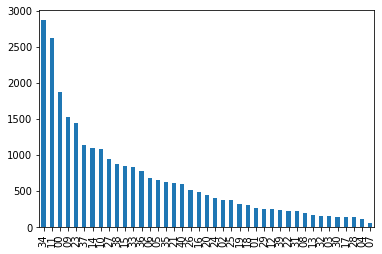

In [22]:
df['label'].value_counts().plot(kind = 'bar')
print(df.groupby('label').size().reset_index(name = 'count'))

In [15]:
tdf = df.copy()

In [21]:
tdf['label'].nunique()

41

In [16]:
from sklearn.model_selection import train_test_split

trainX, testX, trainY, testY = train_test_split(tdf[['input']], tdf['label'],
                                          test_size = 0.2,
                                          shuffle=True,
                                          stratify=tdf['label'],
                                          random_state=2013)
print(len(trainX))
print(len(trainY))
print(len(testX))
print(len(testY))

21628
21628
5407
5407


21628


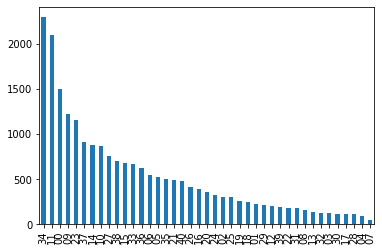

In [33]:
trainY.value_counts().plot(kind = 'bar')
print(trainY.size)

In [17]:
# 문장 추출
sentences = trainX['input'].values
# sentences[:10]
train_dataset = pd.DataFrame({'sentence': sentences, 'label': trainY}, columns=['sentence', 'label'])

# 문장 추출
sentences = testX['input'].values
test_dataset = pd.DataFrame({'sentence': sentences, 'label': testY}, columns=['sentence', 'label'])
sentences[:10]

array(['비 비건 사람 비건 각자 방식 비건 세상 모습 결론 용어 설명 비건 철학 비거니즘 단순 유행 생활 방식 서울시 의회 우리나라 최초 채식 환경 조성 지원 조례 안 통과 시민 건강 증진 식생활 보장 제정 조례 과거 채식 사람 건 일상 말 비건 철학 비거니즘 인간 지구 지배 동물 물건 취급 상황 문제 제기 비건 동물 방식 세상 비건 비건 철학 비거니즘 건 논리 균형 시각 도움 트랜스휴머니즘 해커 청소년 과학 교양서 비 용납 고통 시대 질문 오 고기 동물 동물 고기 동일 한때 동물 고깃덩어리 환경 죽음 모순 일 사람 인간 동물 착취 지배 권리 생각 동물 음식 동물 이용 서비스 반대 사람 건 채식주의자 뜻 베지테리 언 영어 단어 유래 유럽 시작 운동 나라 환경 건강 유행 비건 성 차별 인종 차별 종 차별 종 차별 반대 비건 경우 비 건 모두 환영 사람 음식 문화 식생활 개인 영역 주장 사람 식물 고통 비건 식사 불편 존재 신경 비건 철학 비거니즘 문제 인식 유행 다양 방식 진정 생각 동물 성분 첨가 음식 세상 동물 음식 채식주의자 채식 사람 채식 정도 자신 약속 음식 조금 채식주의자 구분 단어 고기 생선 달걀 유제품 페스 코 베지테리언 채식 상황 고기 생선 달걀 유제품 플렉시테리언 다양 채식주의자 종류 소비 방식 동물 보호 방식 동물 음식 동물 이용 서비스 불매 운동 사람 적극 활동 불매 운동 사람 비거니즘 단순 식 습관 문제 하나 이데올로기 삶 철학 행동 방식 마음 진정 동물 권리 보호 비거니즘 생태 문제 해결 시작 가축 때 온실 가스 암모니아 지구 몸살 생태 환경 속도 생활 방식 환경 영향 목축업 농업 자리 대신 농지 화학 제품 과도 사용 환경 오염 토양 후진국 대안 제시 변화 마찬가지 지향 세상 고민 문제 농장 사육 동물 동물 권리 생물 종 침범 궁리 문제 사람 의견 제각각 세상 걸음 위해 규칙 변화 영향 예측 일 비거니즘 지구 생명체 균형 방법 제안 사회 발전 모두 비건 말 비거니즘 자료 바탕 책 질문 답 저자 플로 랑스 피노 비건 비건 사람 입장

In [18]:
dataset_train = train_dataset.values
dataset_test = test_dataset.values

In [19]:
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)
# tokenizer = get_tokenizer()
# bertmodel, vocab = get_pytorch_kobert_model()
# tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model


In [20]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = []
        self.labels = []
        
        for i in dataset:
            try:
                self.sentences.append(transform([i[sent_idx]]))
                self.labels.append(np.int32(i[label_idx]))
            except Exception as e:
                print(e)
                print(len(self.sentences), len(self.labels))

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [21]:
## Setting parameters
max_len = 128 #128
batch_size = 2 #cuda out of memory ...
warmup_ratio = 0.1
num_epochs = 15
max_grad_norm = 1
log_interval = 200
learning_rate =  2e-5

In [22]:
data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

Argument 'text' has incorrect type (expected str, got float)
1414 1414


In [23]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=2)

In [24]:
NUM_LABELS = 41

In [25]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768, #768 #뭐여 이게.....뭔 조화여 dim이 달라지구로
                 #https://www.google.com/search?sxsrf=ALeKk01zaV-xIa8Z0CUMGLodIa4vl6Z9fg%3A1616147579994&lei=e3RUYIKtPMizmAXPr7D4BA&q=Mat1%20dim%201%20must%20match%20mat2%20dim%200&ved=2ahUKEwjC1qPzirzvAhXIGaYKHc8XDE8QsKwBKAB6BAgUEAE&biw=832&bih=720
                 num_classes=NUM_LABELS,     #9,#num_labels
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [26]:
model = BERTClassifier(bertmodel,  dr_rate=0.25).to(device)

In [27]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [28]:
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [29]:
t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

In [30]:
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [31]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [32]:
from time import gmtime, strftime
START_TIME = strftime("%Y_%m_%d_%H_%M_%S", gmtime())

SAVE_PATH = BASE_PATH+"/bert_model_{}.pth".format(START_TIME)

In [33]:
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(notebook.tqdm(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    
    torch.save(model.state_dict(), SAVE_PATH)
    print("Model saved at {}".format(SAVE_PATH))

    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(notebook.tqdm(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

epoch 1 batch id 1 loss 4.1952362060546875 train acc 0.0
epoch 1 batch id 201 loss 3.9235172271728516 train acc 0.0024875621890547263
epoch 1 batch id 401 loss 3.6880204677581787 train acc 0.008728179551122194
epoch 1 batch id 601 loss 3.712524175643921 train acc 0.01747088186356073
epoch 1 batch id 801 loss 3.221890687942505 train acc 0.0299625468164794
epoch 1 batch id 1001 loss 3.2951436042785645 train acc 0.04945054945054945
epoch 1 batch id 1201 loss 3.9670603275299072 train acc 0.06536219816819318
epoch 1 batch id 1401 loss 3.3736062049865723 train acc 0.08208422555317631
epoch 1 batch id 1601 loss 3.4935240745544434 train acc 0.09962523422860713
epoch 1 batch id 1801 loss 3.7753028869628906 train acc 0.1124375347029428
epoch 1 batch id 2001 loss 3.0929088592529297 train acc 0.1256871564217891
epoch 1 batch id 2201 loss 3.0505876541137695 train acc 0.13811903680145388
epoch 1 batch id 2401 loss 2.631804943084717 train acc 0.1534777176176593
epoch 1 batch id 2601 loss 1.9629480838


epoch 1 test acc 0.5610432852386238


epoch 2 batch id 1 loss 0.992250382900238 train acc 1.0
epoch 2 batch id 201 loss 1.2986963987350464 train acc 0.5422885572139303
epoch 2 batch id 401 loss 0.7743094563484192 train acc 0.5610972568578554
epoch 2 batch id 601 loss 0.03626920282840729 train acc 0.5840266222961731
epoch 2 batch id 801 loss 3.3155648708343506 train acc 0.5886392009987516
epoch 2 batch id 1001 loss 1.8922139406204224 train acc 0.5899100899100899
epoch 2 batch id 1201 loss 3.830176591873169 train acc 0.5940882597835138
epoch 2 batch id 1401 loss 2.0298166275024414 train acc 0.5902926481084939
epoch 2 batch id 1601 loss 1.7568554878234863 train acc 0.594316052467208
epoch 2 batch id 1801 loss 2.1029603481292725 train acc 0.5946696279844531
epoch 2 batch id 2001 loss 0.3031441271305084 train acc 0.5949525237381309
epoch 2 batch id 2201 loss 2.0166172981262207 train acc 0.5920036347114948
epoch 2 batch id 2401 loss 2.6477773189544678 train acc 0.5914202415660141
epoch 2 batch id 2601 loss 0.24411466717720032 tr


epoch 2 test acc 0.6198668146503885


epoch 3 batch id 1 loss 0.05454160273075104 train acc 1.0
epoch 3 batch id 201 loss 1.3866862058639526 train acc 0.6044776119402985
epoch 3 batch id 401 loss 0.8575060963630676 train acc 0.6446384039900249
epoch 3 batch id 601 loss 0.017317913472652435 train acc 0.6547420965058236
epoch 3 batch id 801 loss 1.7040014266967773 train acc 0.6629213483146067
epoch 3 batch id 1001 loss 2.878653049468994 train acc 0.6643356643356644
epoch 3 batch id 1201 loss 4.1825690269470215 train acc 0.6711074104912573
epoch 3 batch id 1401 loss 2.1201932430267334 train acc 0.6638115631691649
epoch 3 batch id 1601 loss 0.976895272731781 train acc 0.6677076826983136
epoch 3 batch id 1801 loss 2.296548366546631 train acc 0.6676846196557468
epoch 3 batch id 2001 loss 0.011044102720916271 train acc 0.6696651674162919
epoch 3 batch id 2201 loss 0.2723940908908844 train acc 0.6690140845070423
epoch 3 batch id 2401 loss 3.1253726482391357 train acc 0.6699291961682632
epoch 3 batch id 2601 loss 0.0090743452310562


epoch 3 test acc 0.6601923788383278


epoch 4 batch id 1 loss 0.01483976375311613 train acc 1.0
epoch 4 batch id 201 loss 0.4054059088230133 train acc 0.7039800995024875
epoch 4 batch id 401 loss 0.01584780216217041 train acc 0.729426433915212
epoch 4 batch id 601 loss 0.00711266091093421 train acc 0.7412645590682196
epoch 4 batch id 801 loss 1.587192177772522 train acc 0.7465667915106118
epoch 4 batch id 1001 loss 2.605541467666626 train acc 0.7477522477522478
epoch 4 batch id 1201 loss 0.029648635536432266 train acc 0.7477102414654455
epoch 4 batch id 1401 loss 0.5281710028648376 train acc 0.7451820128479657
epoch 4 batch id 1601 loss 0.005155247636139393 train acc 0.7476577139287945
epoch 4 batch id 1801 loss 0.6526854038238525 train acc 0.7468073292615214
epoch 4 batch id 2001 loss 0.0036008493043482304 train acc 0.7471264367816092
epoch 4 batch id 2201 loss 0.009067652747035027 train acc 0.7467060427078601
epoch 4 batch id 2401 loss 2.8916311264038086 train acc 0.7476051645147855
epoch 4 batch id 2601 loss 0.009029382


epoch 4 test acc 0.6733259341472438


epoch 5 batch id 1 loss 0.0019945830572396517 train acc 1.0
epoch 5 batch id 201 loss 0.055648889392614365 train acc 0.7711442786069652
epoch 5 batch id 401 loss 0.017656443640589714 train acc 0.7905236907730673
epoch 5 batch id 601 loss 0.0071936435997486115 train acc 0.802828618968386
epoch 5 batch id 801 loss 0.8107866048812866 train acc 0.8014981273408239
epoch 5 batch id 1001 loss 2.812100410461426 train acc 0.7972027972027972
epoch 5 batch id 1201 loss 0.8026526570320129 train acc 0.802248126561199
epoch 5 batch id 1401 loss 0.02318112552165985 train acc 0.7969307637401856
epoch 5 batch id 1601 loss 0.006035539321601391 train acc 0.7973141786383511
epoch 5 batch id 1801 loss 1.4625924825668335 train acc 0.7987229317046085
epoch 5 batch id 2001 loss 0.004215548280626535 train acc 0.8010994502748626
epoch 5 batch id 2201 loss 0.0030398874077945948 train acc 0.8003180372557929
epoch 5 batch id 2401 loss 3.340820074081421 train acc 0.7986255726780508
epoch 5 batch id 2601 loss 0.0048


epoch 5 test acc 0.6859045504994451


epoch 6 batch id 1 loss 0.002151571912690997 train acc 1.0
epoch 6 batch id 201 loss 1.701898217201233 train acc 0.8283582089552238
epoch 6 batch id 401 loss 0.0028300799895077944 train acc 0.8366583541147132
epoch 6 batch id 601 loss 0.006510305218398571 train acc 0.846089850249584
epoch 6 batch id 801 loss 0.0029325801879167557 train acc 0.846441947565543
epoch 6 batch id 1001 loss 2.5838112831115723 train acc 0.8436563436563437
epoch 6 batch id 1201 loss 0.0024114041589200497 train acc 0.8517901748542881
epoch 6 batch id 1401 loss 0.631058931350708 train acc 0.8508208422555318
epoch 6 batch id 1601 loss 0.0015370859764516354 train acc 0.8510306058713304
epoch 6 batch id 1801 loss 5.481506824493408 train acc 0.8503609106052193
epoch 6 batch id 2001 loss 0.001517738914117217 train acc 0.8500749625187406
epoch 6 batch id 2201 loss 0.021334482356905937 train acc 0.8496138119036801
epoch 6 batch id 2401 loss 3.317918062210083 train acc 0.8477717617659308
epoch 6 batch id 2601 loss 0.0078


epoch 6 test acc 0.6918238993710691


epoch 7 batch id 1 loss 0.0009793346980586648 train acc 1.0
epoch 7 batch id 201 loss 0.002494484419003129 train acc 0.8855721393034826
epoch 7 batch id 401 loss 0.0024381810799241066 train acc 0.885286783042394
epoch 7 batch id 601 loss 0.0062595559284091 train acc 0.8960066555740432
epoch 7 batch id 801 loss 0.002688551554456353 train acc 0.8938826466916354
epoch 7 batch id 1001 loss 4.77249002456665 train acc 0.8891108891108891
epoch 7 batch id 1201 loss 0.0033992608077824116 train acc 0.8900915903413822
epoch 7 batch id 1401 loss 0.0017823600210249424 train acc 0.8897216274089935
epoch 7 batch id 1601 loss 0.000649501453153789 train acc 0.8906933166770769
epoch 7 batch id 1801 loss 0.04743077978491783 train acc 0.889505830094392
epoch 7 batch id 2001 loss 0.0006185355596244335 train acc 0.889055472263868
epoch 7 batch id 2201 loss 0.0024117627181112766 train acc 0.8905043162199
epoch 7 batch id 2401 loss 3.698240280151367 train acc 0.8898375676801332
epoch 7 batch id 2601 loss 0.00


epoch 7 test acc 0.7155012948575656


epoch 8 batch id 1 loss 0.00046897761058062315 train acc 1.0
epoch 8 batch id 201 loss 0.0008841408416628838 train acc 0.9079601990049752
epoch 8 batch id 401 loss 0.0008116657263599336 train acc 0.9027431421446384
epoch 8 batch id 601 loss 0.004410600755363703 train acc 0.910981697171381
epoch 8 batch id 801 loss 0.0013865212677046657 train acc 0.9119850187265918
epoch 8 batch id 1001 loss 3.219151496887207 train acc 0.9125874125874126
epoch 8 batch id 1201 loss 0.0009523187763988972 train acc 0.9134054954204829
epoch 8 batch id 1401 loss 0.0009670634754002094 train acc 0.913633119200571
epoch 8 batch id 1601 loss 0.0014601834118366241 train acc 0.9138038725796377
epoch 8 batch id 1801 loss 0.0016980034997686744 train acc 0.9153248195446974
epoch 8 batch id 2001 loss 0.0004484236123971641 train acc 0.9150424787606197
epoch 8 batch id 2201 loss 0.0010730460053309798 train acc 0.9157201272149024
epoch 8 batch id 2401 loss 0.014973267912864685 train acc 0.914618908788005
epoch 8 batch id


epoch 8 test acc 0.7267850536440992


epoch 9 batch id 1 loss 0.0007917993934825063 train acc 1.0
epoch 9 batch id 201 loss 0.00047700630966573954 train acc 0.927860696517413
epoch 9 batch id 401 loss 0.038120415061712265 train acc 0.928927680798005
epoch 9 batch id 601 loss 0.0034142073709517717 train acc 0.9309484193011647
epoch 9 batch id 801 loss 0.0030837245285511017 train acc 0.9325842696629213
epoch 9 batch id 1001 loss 3.1093804836273193 train acc 0.9330669330669331
epoch 9 batch id 1201 loss 0.007701834663748741 train acc 0.9342214820982515
epoch 9 batch id 1401 loss 0.004135172814130783 train acc 0.9350463954318344
epoch 9 batch id 1601 loss 0.00036453420761972666 train acc 0.9359775140537164
epoch 9 batch id 1801 loss 0.0018607284873723984 train acc 0.9367018323153803
epoch 9 batch id 2001 loss 0.00031233858317136765 train acc 0.9357821089455273
epoch 9 batch id 2201 loss 0.00032336084404960275 train acc 0.9354838709677419
epoch 9 batch id 2401 loss 0.0007954552420414984 train acc 0.9348188254893794
epoch 9 batc


epoch 9 test acc 0.7247502774694784


epoch 10 batch id 1 loss 0.0004891639109700918 train acc 1.0
epoch 10 batch id 201 loss 0.00042190318345092237 train acc 0.9527363184079602
epoch 10 batch id 401 loss 0.00034731539199128747 train acc 0.9476309226932669
epoch 10 batch id 601 loss 0.0018435509409755468 train acc 0.9509151414309485
epoch 10 batch id 801 loss 0.00041605887236073613 train acc 0.9538077403245943
epoch 10 batch id 1001 loss 2.7920308113098145 train acc 0.9515484515484516
epoch 10 batch id 1201 loss 0.0001971488236449659 train acc 0.9533721898417985
epoch 10 batch id 1401 loss 0.0010728467023000121 train acc 0.9521770164168452
epoch 10 batch id 1601 loss 0.00019202622934244573 train acc 0.9531542785758901
epoch 10 batch id 1801 loss 0.00040896140853874385 train acc 0.9555802332037757
epoch 10 batch id 2001 loss 0.00020162208238616586 train acc 0.955272363818091
epoch 10 batch id 2201 loss 0.00019667527521960437 train acc 0.9561562925942754
epoch 10 batch id 2401 loss 0.00035428302362561226 train acc 0.95605997


epoch 10 test acc 0.7367739548649649


epoch 11 batch id 1 loss 0.00023022083041723818 train acc 1.0
epoch 11 batch id 201 loss 0.0002638348378241062 train acc 0.9676616915422885
epoch 11 batch id 401 loss 0.00048685140791349113 train acc 0.9675810473815462
epoch 11 batch id 601 loss 0.0007040399359539151 train acc 0.9667221297836939
epoch 11 batch id 801 loss 0.0003098954330198467 train acc 0.9681647940074907
epoch 11 batch id 1001 loss 0.9563748836517334 train acc 0.965034965034965
epoch 11 batch id 1201 loss 0.00036685221130028367 train acc 0.9658617818484596
epoch 11 batch id 1401 loss 0.00022872877889312804 train acc 0.9685938615274804
epoch 11 batch id 1601 loss 0.0002742022625170648 train acc 0.9687695190505934
epoch 11 batch id 1801 loss 0.00044383294880390167 train acc 0.9691837867851194
epoch 11 batch id 2001 loss 0.0002761073410511017 train acc 0.9692653673163418
epoch 11 batch id 2201 loss 5.018577940063551e-05 train acc 0.9700136301681054
epoch 11 batch id 2401 loss 0.00017188480705954134 train acc 0.9689712619


epoch 11 test acc 0.7354790972992971


epoch 12 batch id 1 loss 0.00028677325462922454 train acc 1.0
epoch 12 batch id 201 loss 0.00014435191405937076 train acc 0.9751243781094527
epoch 12 batch id 401 loss 0.00013880929327569902 train acc 0.9763092269326683
epoch 12 batch id 601 loss 0.0006398864788934588 train acc 0.9767054908485857
epoch 12 batch id 801 loss 0.0001828500535339117 train acc 0.9781523096129837
epoch 12 batch id 1001 loss 0.004817976150661707 train acc 0.9775224775224776
epoch 12 batch id 1201 loss 0.0003939860325772315 train acc 0.9766860949208993
epoch 12 batch id 1401 loss 0.00028395812842063606 train acc 0.9785867237687366
epoch 12 batch id 1601 loss 0.00011806958355009556 train acc 0.9784509681449094
epoch 12 batch id 1801 loss 0.000222658141865395 train acc 0.9797334813992227
epoch 12 batch id 2001 loss 0.00013493536971509457 train acc 0.9802598700649675
epoch 12 batch id 2201 loss 0.00013010596740059555 train acc 0.9802362562471604
epoch 12 batch id 2401 loss 0.0013045617379248142 train acc 0.9791753


epoch 12 test acc 0.7399186089530152


epoch 13 batch id 1 loss 0.0001523366809124127 train acc 1.0
epoch 13 batch id 201 loss 0.0002538772823754698 train acc 0.9850746268656716
epoch 13 batch id 401 loss 0.00022360979346558452 train acc 0.9875311720698254
epoch 13 batch id 601 loss 0.00038336217403411865 train acc 0.9866888519134775
epoch 13 batch id 801 loss 0.00017009190923999995 train acc 0.9881398252184769
epoch 13 batch id 1001 loss 0.0003204370732419193 train acc 0.986013986013986
epoch 13 batch id 1201 loss 0.0001874353038147092 train acc 0.9858451290591174
epoch 13 batch id 1401 loss 0.00010817595466505736 train acc 0.9867951463240543
epoch 13 batch id 1601 loss 0.00012861820869147778 train acc 0.9871955028107433
epoch 13 batch id 1801 loss 0.0002459569077473134 train acc 0.9875069405885619
epoch 13 batch id 2001 loss 9.083284385269508e-05 train acc 0.9877561219390305
epoch 13 batch id 2201 loss 0.0001100821464206092 train acc 0.987732848705134
epoch 13 batch id 2401 loss 6.44298706902191e-05 train acc 0.9872969596


epoch 13 test acc 0.7475027746947835


epoch 14 batch id 1 loss 0.00014655623817816377 train acc 1.0
epoch 14 batch id 201 loss 8.689866808708757e-05 train acc 0.9900497512437811
epoch 14 batch id 401 loss 7.742285379208624e-05 train acc 0.9912718204488778
epoch 14 batch id 601 loss 0.00023034540936350822 train acc 0.9908485856905158
epoch 14 batch id 801 loss 7.343010656768456e-05 train acc 0.9906367041198502
epoch 14 batch id 1001 loss 0.00014679133892059326 train acc 0.9895104895104895
epoch 14 batch id 1201 loss 8.719778270460665e-05 train acc 0.988759367194005
epoch 14 batch id 1401 loss 0.0001435172016499564 train acc 0.9892933618843683
epoch 14 batch id 1601 loss 7.396662113023922e-05 train acc 0.990318550905684
epoch 14 batch id 1801 loss 0.00033867533784359694 train acc 0.9908384230982787
epoch 14 batch id 2001 loss 7.56950321374461e-05 train acc 0.9912543728135932
epoch 14 batch id 2201 loss 4.011298005934805e-05 train acc 0.9913675601999091
epoch 14 batch id 2401 loss 0.00014267915685195476 train acc 0.9910453977


epoch 14 test acc 0.7495375508694043


epoch 15 batch id 1 loss 8.391979645239189e-05 train acc 1.0
epoch 15 batch id 201 loss 9.119075548369437e-05 train acc 0.9950248756218906
epoch 15 batch id 401 loss 8.71972442837432e-05 train acc 0.9962593516209476
epoch 15 batch id 601 loss 0.0002127636835211888 train acc 0.9950083194675541
epoch 15 batch id 801 loss 0.00012235986650921404 train acc 0.9943820224719101
epoch 15 batch id 1001 loss 0.00030277753830887377 train acc 0.9945054945054945
epoch 15 batch id 1201 loss 7.867404929129407e-05 train acc 0.9937552039966694
epoch 15 batch id 1401 loss 8.91637901077047e-05 train acc 0.9939329050678087
epoch 15 batch id 1601 loss 0.00011985705350525677 train acc 0.9937539038101186
epoch 15 batch id 1801 loss 0.00023189454805105925 train acc 0.9941699056079956
epoch 15 batch id 2001 loss 0.00010150051093660295 train acc 0.9942528735632183
epoch 15 batch id 2201 loss 3.7490419344976544e-05 train acc 0.9943207632894139
epoch 15 batch id 2401 loss 9.935451089404523e-05 train acc 0.99416909


epoch 15 test acc 0.7495375508694043


In [1]:
print("hi")

hi


In [ ]:
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(notebook.tqdm(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    
    torch.save(model.state_dict(), SAVE_PATH)
    print("Model saved at {}".format(SAVE_PATH))

    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(notebook.tqdm(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

In [66]:
from sklearn.metrics import classification_report

y_result = []
y_answer = []

model.eval()
for dummy, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
    token_ids = token_ids.long().to(device)
    segment_ids = segment_ids.long().to(device)
    valid_length= valid_length
    label = label.long().to(device)
    out = model(token_ids, valid_length, segment_ids)
    copied = out.data.cpu().numpy()
    for ik in copied:
        y_result.append(list(ik).index(max(ik)))
    for la in label:
        y_answer.append(la.item())

# ndarray, tensor
# 멀기만하구나....길은 참.

print(classification_report(y_answer, y_result))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87       374
           1       0.35      0.52      0.42        54
           2       0.54      0.55      0.54        75
           3       0.54      0.63      0.58        30
           4       0.42      0.43      0.43        23
           5       0.73      0.69      0.71       131
           6       0.59      0.49      0.53       136
           7       0.27      0.33      0.30        12
           8       0.76      0.74      0.75        39
           9       0.95      0.93      0.94       305
          10       0.58      0.60      0.59       217
          11       0.80      0.87      0.83       524
          12       0.43      0.39      0.41        49
          13       0.57      0.47      0.52        34
          14       0.83      0.84      0.84       219
          15       0.66      0.71      0.68       169
          16       0.84      0.84      0.84        97
          17       0.62    

In [67]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 161kB/s 
     |████████████████████████████████| 460kB 49.4MB/s 
     |████████████████████████████████| 92kB 12.1MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
from konlpy.tag import Twitter
from sklearn.feature_extraction.text import TfidfVectorizer

class MyTokenizerN:
  def __init__(self, tagger):
    self.tagger = tagger
  def __call__(self, sent):
    pos = self.tagger.nouns(sent)
    return pos

my_tokN = MyTokenizerN(Twitter())

vectorizer = TfidfVectorizer(tokenizer=my_tokN, max_features=1000)
X = vectorizer.fit_transform(tdf['input'])

/usr/local/lib/python3.7/dist-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


ValueError: ignored

In [ ]:
X_array = X.toarray()
X_dict = vectorizer.get_feature_names()
Xdf = pd.DataFrame(X_array, columns=X_dict)
Xdf.shape

In [ ]:
from sklearn.model_selection import train_test_split

X_tr2, X_ts2, y_tr2, y_ts2 = train_test_split(Xdf, tdf['label'],
                                          test_size = 0.3,
                                          shuffle=True,
                                          stratify=tdf['label'],
                                          random_state=2013)
print(X_tr2.shape)
print(y_tr2.shape)
print(X_ts2.shape)
print(y_ts2.shape)

In [ ]:
X_va2, X_ts2, y_va2, y_ts2 = train_test_split(X_ts2, y_ts2,
                                          test_size = 0.5,
                                          shuffle=True,
                                          stratify=y_ts2,
                                          random_state=2013)
print(X_va2.shape)
print(y_va2.shape)
print(X_ts2.shape)
print(y_ts2.shape)

In [70]:
from sklearn.ensemble import RandomForestClassifier

rf2 = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=2013)
rf2.fit(X_tr2, y_tr2)

from sklearn.metrics import accuracy_score

predicted2 = rf2.predict(X_ts2)
accuracy2 = accuracy_score(y_ts2, predicted2)

print(f'Out-of-bag score estimate: {rf2.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy2:.3}')

NameError: ignored

In [ ]:
from sklearn.svm import SVC

clf = SVC(kernel='linear')

clf.fit(X_tr2, y_tr2)

# clf_predictions = clf.predict(X_ts2)
print("Accuracy: {}%".format(clf.score(X_ts2, y_ts2)))

In [ ]:
from sklearn.metrics import classification_report

# y_result = []
# y_answer = []

print(classification_report(y_ts2, clf.predict(X_ts2)))

In [69]:
print("hi")

hi


In [ ]:
from sklearn.metrics import classification_report

# y_result = []
# y_answer = []

print(classification_report(y_ts2, predicted2))